In [1]:
import math
import logging

import torch
import torch.nn as nn
from torch.nn import functional as F

import pytorch_lightning as pl
import matplotlib.pyplot as plt

In [17]:
import d4rl
import gym
import numpy as np
import math
import logging

import torch
import torch.nn as nn
from torch.nn import functional as F


from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

class PointmassBCDataset(Dataset):

    def __init__(self, name='maze2d-open-v0', block_size=64):
        
        self.block_size = block_size
        
        env = gym.make(name)
        self.data = env.get_dataset()
        self.obses = self.data['observations']
  
        self.acs = self.data['actions']
    
    
    def __len__(self):
        return len(self.obses) - self.block_size

    def __getitem__(self, idx):
        # grab a chunk of (block_size + 1) characters from the data
        obses = self.obses[idx:idx + self.block_size]
        acs = self.acs[idx:idx + self.block_size]
        
        x = torch.tensor(obses, dtype=torch.float)
        y = torch.tensor(acs, dtype=torch.float)
        return x, y
    
dataset = PointmassBCDataset()

loader = DataLoader(dataset, shuffle=True, pin_memory=True,
                                batch_size=512,
                                num_workers=4)


load datafile: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 19.02it/s]


In [18]:
x, y = next(iter(loader))
goals = torch.cat([x[:,-1:,:] for _ in range(64)],1)
torch.cat((x,goals),-1).shape

torch.Size([512, 64, 8])

In [19]:
class BCMLP(nn.Module):
    
    def __init__(self, conf):
        super().__init__()

        h_dim = conf.h_dim
        self.obs_dim = obs_dim = conf.obs_dim
        self.goal_dim = goal_dim = conf.goal_dim
        
        ac_dim = conf.ac_dim
        self.obs_dim = obs_dim
        
        self.mlp = nn.Sequential(nn.Linear(obs_dim + goal_dim, h_dim),
                                 nn.ReLU(),
                                 nn.Linear(h_dim, h_dim),
                                 nn.ReLU(),
                                 nn.Linear(h_dim, h_dim),
                                 nn.ReLU(),
                                 nn.Linear(h_dim, h_dim),
                                 nn.ReLU(),
                                 nn.Linear(h_dim, ac_dim)
                                )
                
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def forward(self, x):
        B, T, C = x.shape
        
        # goal is that last state
#         goals = torch.cat([x[:,-1:,:] for _ in range(T)],1)[..., :self.goal_dim]
#         goal_obs = torch.cat((x[..., :self.obs_dim],goals),-1)
        
        # goal is first and last state
        goal_vec = torch.cat([x[:, :1], x[:, -1:]], -1)
        goals = torch.cat([goal_vec for _ in range(T)],1)
        goal_obs = torch.cat((x[..., :self.obs_dim], goals),-1)
        
        goal_obs = goal_obs.view(-1,self.obs_dim + self.goal_dim)
        pred_ac = self.mlp(goal_obs)
                
        return pred_ac
    
    
    def bc_loss(self, pred_ac, target_ac):
     
        pred_ac = pred_ac.view(-1, pred_ac.shape[-1])
        target_ac = target_ac.view(-1, target_ac.shape[-1])
        loss = F.mse_loss(pred_ac, target_ac)
        
        return loss
        

        

In [20]:
import tqdm 

class GPTConfig:
    """ base GPT config, params common to all GPT versions """
    embd_pdrop = 0.1
    resid_pdrop = 0.1
    attn_pdrop = 0.1
    
    

    def __init__(self, vocab_size=2, block_size=64, 
                 n_layer=4, n_head=8, n_embd=512, obs_dim=4, ac_dim=2, goal_dim=4):
        self.vocab_size = vocab_size
        self.block_size = block_size

        self.n_layer=n_layer
        self.n_head=n_head
        self.h_dim=n_embd 
        
        self.in_dim = vocab_size
        self.out_dim = vocab_size
        self.max_T = block_size
        
        self.obs_dim = obs_dim
        self.ac_dim = ac_dim
        self.goal_dim = goal_dim
     
       

obs_dim = 4
goal_dim = 4 * 2
conf = GPTConfig(6, 64,
                  n_layer=2, n_head=8, n_embd=256, obs_dim=obs_dim, goal_dim=goal_dim,
                  )
model = BCMLP(conf)

weight_decay=1e-4
learning_rate=1e-4
betas=(0.99,0.999)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=betas)

device = torch.device('cuda')

model = model.to(device)

losses = []
epochs = 10

In [21]:
for epoch in range(epochs):
    pbar = tqdm.tqdm(enumerate(loader), total=len(loader)) if True else enumerate(loader)

    for it, (x, y) in pbar:

        # place data on the correct device
        x = x.to(device).float()

        y = y.to(device).float()

        # forward the model
        with torch.set_grad_enabled(True):
            y = y.view(-1, y.shape[-1])
            pred_ac = model.forward(x)

            loss = model.bc_loss(pred_ac, y)
            loss = loss.mean() # collapse all losses if they are scattered on multiple gpus
            losses.append(loss.item())
            model.zero_grad()
            loss.backward()
            optimizer.step()

        if it % 1000 == 0:
            print(loss.item())

        #if it == 5000:
        #    break

  1%|█▊                                                                                                                                                                           | 21/1953 [00:00<00:18, 104.39it/s]

0.5733458399772644


 53%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 1026/1953 [00:08<00:06, 133.20it/s]

0.31870296597480774


  1%|██▍                                                                                                                                                                          | 27/1953 [00:00<00:14, 129.36it/s]

0.27840983867645264


 52%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 1018/1953 [00:08<00:06, 133.90it/s]

0.2467641532421112


  1%|█▉                                                                                                                                                                           | 22/1953 [00:00<00:17, 108.86it/s]

0.21929249167442322


 52%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1020/1953 [00:07<00:07, 132.22it/s]

0.21001499891281128


  1%|█▉                                                                                                                                                                           | 22/1953 [00:00<00:17, 111.79it/s]

0.20531176030635834


 52%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 1022/1953 [00:07<00:07, 130.22it/s]

0.1922561228275299


  1%|██                                                                                                                                                                           | 23/1953 [00:00<00:16, 114.71it/s]

0.18238183856010437


 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 1013/1953 [00:07<00:07, 127.89it/s]

0.1783563792705536


  1%|██▏                                                                                                                                                                          | 24/1953 [00:00<00:16, 117.45it/s]

0.1735353171825409


 52%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 1017/1953 [00:07<00:07, 130.46it/s]

0.16467070579528809


  1%|██▏                                                                                                                                                                          | 24/1953 [00:00<00:16, 115.83it/s]

0.16494068503379822


 52%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 1022/1953 [00:07<00:07, 131.58it/s]

0.15853935480117798


  1%|██▏                                                                                                                                                                          | 24/1953 [00:00<00:16, 116.81it/s]

0.15167230367660522


 52%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 1022/1953 [00:07<00:07, 132.14it/s]

0.14495626091957092


  1%|██                                                                                                                                                                           | 23/1953 [00:00<00:16, 115.06it/s]

0.15505990386009216


 52%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1020/1953 [00:07<00:07, 131.74it/s]

0.15500259399414062


  1%|██                                                                                                                                                                           | 23/1953 [00:00<00:16, 115.25it/s]

0.1393570601940155


 52%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1020/1953 [00:07<00:07, 132.68it/s]

0.14523203670978546


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1953/1953 [00:15<00:00, 127.61it/s]


0.13166412711143494


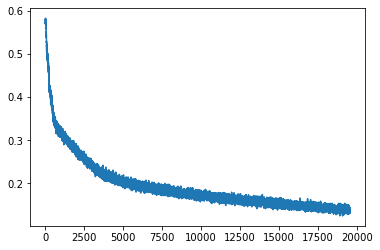

In [22]:
plt.plot(losses)
print(losses[-1])

Global seed set to 10


[345353 760957 881167 443712 617841 105595 533660 927705 299741 804336
 108445 278385 960506 140296 795721 710912]


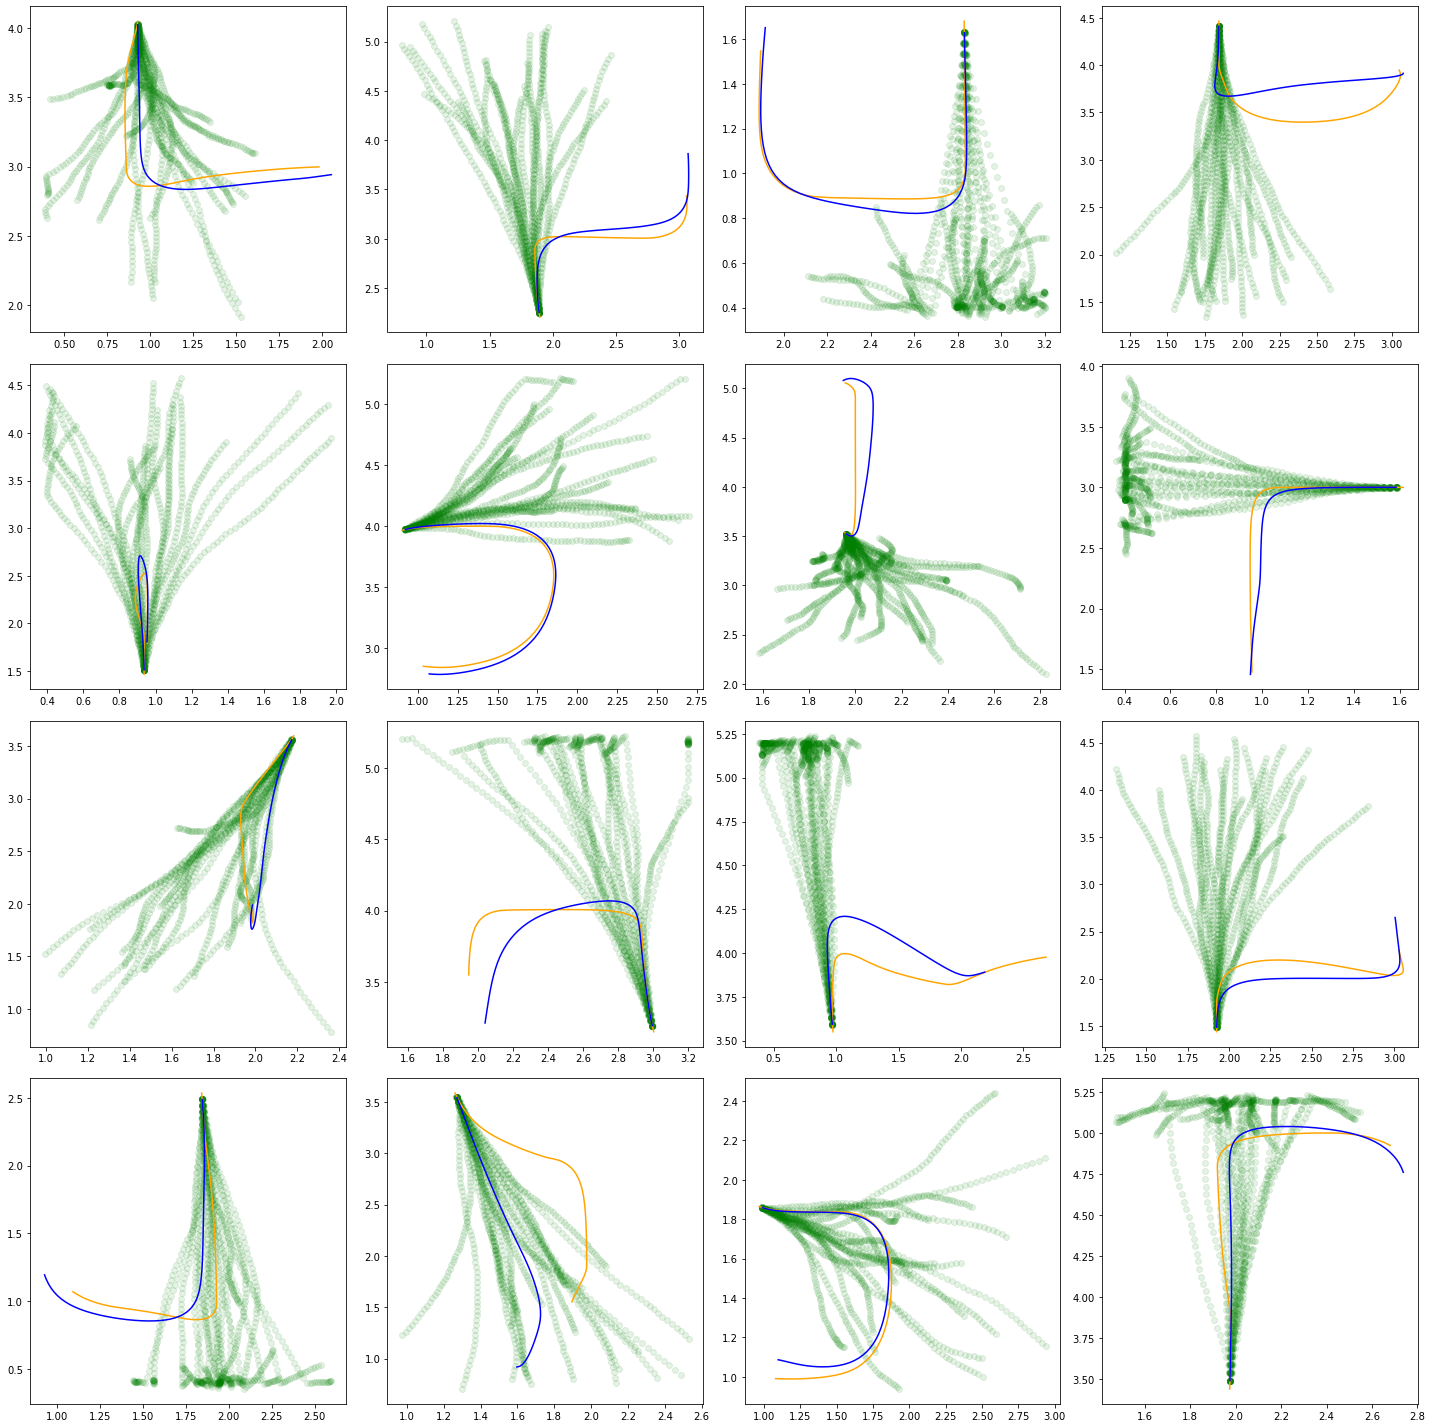

In [28]:
env = gym.make('maze2d-open-v0')

pl.seed_everything(10)
rand_idx = np.random.randint(0, len(dataset), size=(16,))
print(rand_idx)

x, y = [], []
for idx in rand_idx:
    xi, yi = dataset[idx]
    x.append(xi)
    y.append(yi)
x = torch.stack(x, 0)
y = torch.stack(y, 0)

x = x.to(device).float()

x_lims = [x[:,0].min().item(), x[:,0].max().item()]
y_lims = [x[:,1].min().item(), x[:,1].max().item()]

steps = 64

fig, axs = plt.subplots(4,4, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
fig.tight_layout()
axs = axs.ravel()

goals = torch.cat([x[:,:1], x[:, -1:]], -1)
# goals = x[:, -1:]

# 12 21 28 29 33 34
for idx in range(16):

    
    qpos = x[idx][0][:2].detach().cpu().numpy()
    qvel = x[idx][0][2:4].detach().cpu().numpy()

    env.reset()
    env.set_state(qpos,qvel)

    rand = []
    for _ in range(20):
        env.reset()
        env.set_state(qpos,qvel)

        for _ in range(steps):
            s, r, d, _ = env.step(env.action_space.sample())
            rand.append(s[:2])

    osil = []

    for _ in range(1):
        env.reset()
        env.set_state(qpos,qvel)
        s = x[idx][0] #.detach().cpu().numpy()
        
        goal = goals[idx] 
        
        for _ in range(steps):
            ac = model.mlp(torch.cat((s[:obs_dim][None],goal), -1))
#             ac = model.mlp(torch.cat((s[None][..., :obs_dim],goal[..., :goal_dim]),1))
            
            s, r, d, _ = env.step(ac.detach().cpu().numpy())
            osil.append(s[:2])
            s = torch.as_tensor(s, dtype=x.dtype, device= x.device)

    osil = np.array(osil)

    rand = np.array(rand)
    #plt.scatter([qpos[0]],[qpos[1]])
    #plt.scatter(rand[:,0], rand[:,1], c='g',alpha=0.1)
    #plt.plot(osil[:steps,0], osil[:steps,1],c='b')
    #plt.plot(x[idx,:steps,0].detach().cpu().numpy(), x[idx,:steps,1].detach().cpu().numpy(),c='orange')
    #plt.show()
    axs[idx].scatter(rand[:,0], rand[:,1], c='g',alpha=0.1)
    axs[idx].plot(x[idx,:steps,0].detach().cpu().numpy(), x[idx,:steps,1].detach().cpu().numpy(),c='orange')
    axs[idx].plot(osil[:steps,0], osil[:steps,1],c='b')
    #axs[idx].set_xlim(*x_lims)
    #axs[idx].set_ylim(*y_lims)
    #axs[i].set_title(str(250+i))
    


In [30]:
torch.save({
            'epoch': 10,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': np.mean(losses[-100:])
            }, './goal_bc.pt')

In [1]:
acts = []
for i in range(1000):
    acts.append(env.action_space.sample())
    
acts = np.stack(acts, 0)

NameError: name 'env' is not defined